In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Daily, Hourly, Monthly, Point, Stations
from lets_plot import *
from lets_plot.geo_data import *
import numpy as np
import pandas as pd
LetsPlot.setup_html()

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


In this little exercise, we explore how the average temperature changes in London city circle with simple statistics.

The goal is to build a simple predictive model of temperature as a function of city population, which is treated as a proxy of local economic activities that may affect the local weather.

With the package $\texttt{meteostat}$ and $\texttt{lets-plot}$, we can collect the weather data and visualise them conveniently.
Here we pick the station within 25km around London's centre.

In [2]:
# Get all the stations in United Kingdom
stations = Stations()
sts = stations.region("GB")
# Get all the stations within 25 km of London
sts_LD = stations.nearby(51.509865, -0.118092, radius=25000)
sts = sts.fetch()
sts_LD = sts_LD.fetch()

LD = geocode_cities(names="London").inc_res().get_boundaries()
points = geom_point(
    aes(x="longitude", y="latitude"), data=sts_LD, alpha=1.0, shape=18, color="#7570b3", size = 10
)
(
    ggplot()
    + geom_livemap()
    + geom_polygon(data=LD, fill="#F8F4F0", color="#B71234", alpha=0.1)
    + points
    + ggsize(650, 600)
)



Let's explore the time series from 1954 to 2024, which is averaged over the station selected with missing data dropped out.

In [3]:
start, end = datetime(1954, 9, 1), datetime(2024, 9, 1)
def get_cleaned_temperature_data(sts=sts_LD, start=start, end=end, interval=Monthly):
    data = interval(sts, start=start, end=end)
    data = data.fetch().reset_index()
    data_cleaned = data[~data['tavg'].isna()]
    return data_cleaned

LD_monthly = get_cleaned_temperature_data(sts, interval=Monthly)

Plot and see how the data looks like.

Text(0, 0.5, 'Temperature in Celcius')

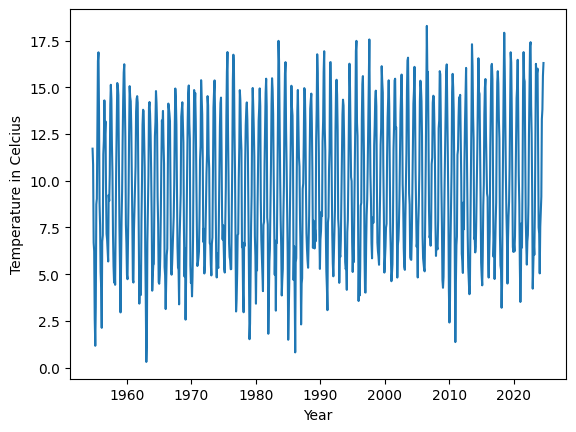

In [4]:
LD_monthly_avg_over_sts = LD_monthly.groupby("time")[['tmax', 'tavg', 'tmin']].mean().reset_index()
plt.plot(LD_monthly_avg_over_sts['time'], LD_monthly_avg_over_sts['tavg'])
plt.xlabel('Year')
plt.ylabel('Temperature in Celcius')

Obviously we expect the seasonal changes on top of the trend. As a college exercise, let's do a Fourier transform to double check.

(0.0, 8589.198517480274)

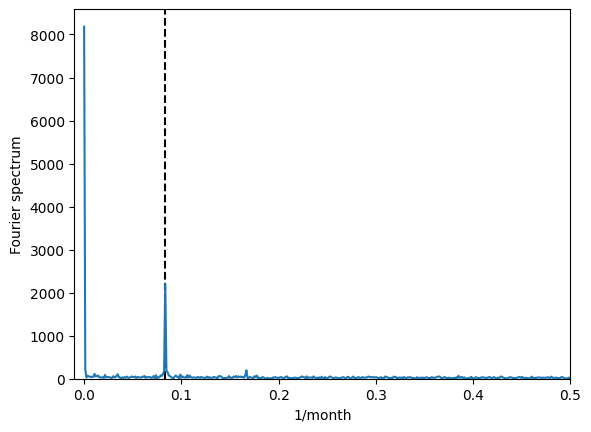

In [5]:
spectrum = np.fft.rfft(LD_monthly_avg_over_sts['tavg'])
freqs = np.fft.rfftfreq(len(LD_monthly_avg_over_sts))
plt.axvline(x=1./12.0, c='k', ls='--')
plt.plot(freqs, np.abs(spectrum))
plt.xlabel("1/month")
plt.ylabel("Fourier spectrum")
plt.xlim(-0.01, 0.5)
plt.ylim(bottom=0)

In above, the peak at 0 frequency corresponds to the constant offset. The non-trivial peak is located at a period of 12 months, matching our expectations of having 4 seasons in 1 year.

Now, we are interested in finding some long-term trend in the time series.
First, we remove the seasonal trend by taking annual averages.

In [6]:
LD_monthly_avg_over_sts["year"] = LD_monthly_avg_over_sts["time"].dt.strftime("%Y")
LD_yearly_avg_over_sts = LD_monthly_avg_over_sts.groupby("year")[['tmax', 'tavg', 'tmin']].mean().reset_index()

Let's also compute a moving average (we use exponential moving average for smoothing) to see if there are large fluctuations.

In [7]:
span = 10 #a smoothing window of a decade
LD_yearly_avg_over_sts["tavg_ema"] = LD_yearly_avg_over_sts['tavg'].ewm(span=span).mean()

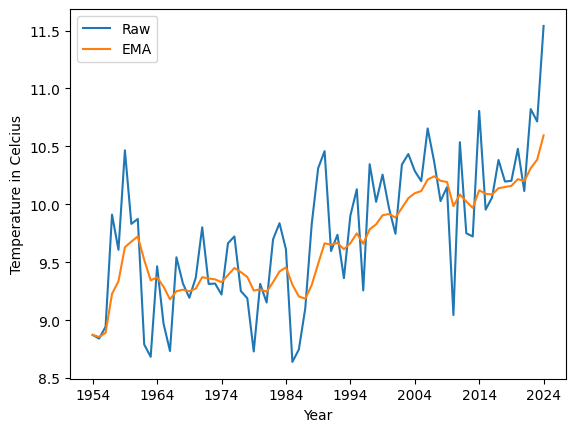

In [8]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_yearly_avg_over_sts["year"], LD_yearly_avg_over_sts["tavg"], label="Raw")
ax.plot(LD_yearly_avg_over_sts["year"], LD_yearly_avg_over_sts["tavg_ema"], label="EMA")
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);
ax.set_xlabel("Year")
ax.set_ylabel("Temperature in Celcius")
ax.legend()

Indeed, there is a clear increasing trend! Let's have a crude estimation on whether this trend is linear or quadratic, by fitting two models and comparing the mean-squared error.

In [9]:
y = LD_yearly_avg_over_sts["tavg"]
x = np.arange(0, len(y))
def get_polyfit(x, y, degree):
    coeff = np.polyfit(x, y, degree)
    yfit = np.poly1d(coeff)(x)
    residue = np.mean((yfit - y)**2)
    return yfit, residue

In [10]:
y_quad, res_quad = get_polyfit(x, y, 2)
y_lin, res_lin = get_polyfit(x, y, 1)

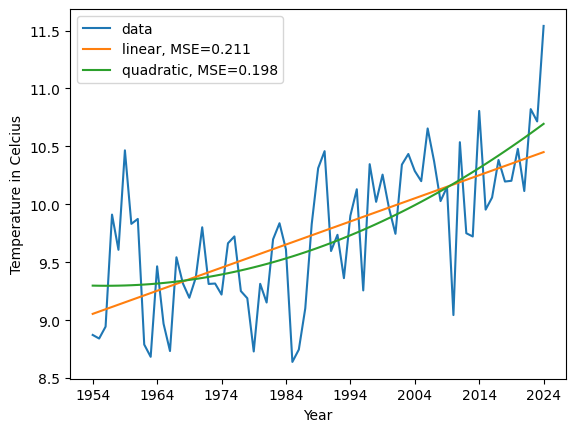

In [11]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_yearly_avg_over_sts["year"], LD_yearly_avg_over_sts["tavg"], label='data')
ax.plot(x, y_lin, label="linear, MSE={0:.3f}".format(res_lin))
ax.plot(x, y_quad, label="quadratic, MSE={0:.3f}".format(res_quad))
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);
ax.legend();
ax.set_xlabel("Year");
ax.set_ylabel("Temperature in Celcius");

The quadratic model is slightly better. But what's the cause of the increase? Let's try correlate with the population data in London as well. Source: https://www.macrotrends.net/global-metrics/cities/22860/london/population

In [12]:
LD_pop = pd.read_csv("London-population-yearly.csv")

Do some format cleaning 

In [16]:
LD_pop = LD_pop.rename(columns={' Population': "population"})
LD_pop.date = pd.to_datetime(LD_pop.date, dayfirst=True)
LD_pop["year"] = LD_pop.date.dt.strftime("%Y")

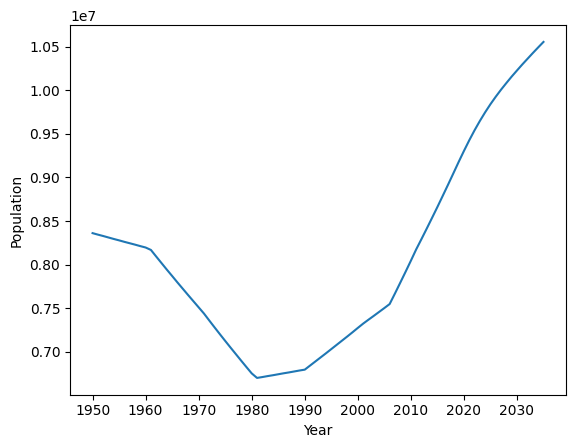

In [19]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_pop.year, LD_pop.population)
ax.set_xlabel("Year")
ax.set_ylabel("Population")
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);

Let's try normalising the population data and temperature data, then overlaying them on the same plot.

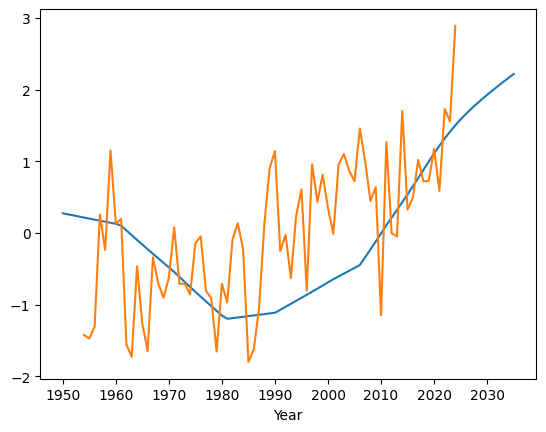

In [61]:
def min_max_norm(y):
    return (y - y.mean()) / (y.max() - y.min())

def std_norm(y):
    return (y - y.mean()) / y.std()

LD_pop["population_norm"] = std_norm(LD_pop.population)
LD_yearly_avg_over_sts["tavg_norm"] = std_norm(LD_yearly_avg_over_sts.tavg)
LD_yearly_avg_over_sts["tavg_ema_norm"] = std_norm(LD_yearly_avg_over_sts.tavg_ema)

fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_pop.year.values, LD_pop["population_norm"])
ax.plot(LD_yearly_avg_over_sts.year.values, LD_yearly_avg_over_sts["tavg_norm"])
ax.set_xlabel("Year")
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);

There seems to be some correlation between two series. Let's check with a cross-correlation.

In [49]:
start, end = "1954", "2024"
pop_norm = LD_pop[(LD_pop.year <= end) & (LD_pop.year >= start)].population_norm.values
temp_norm = LD_yearly_avg_over_sts.tavg_norm.values
time = np.arange(0, int(end) - int(start) + 1, 1)

Text(0, 0.5, 'Cross correlation')

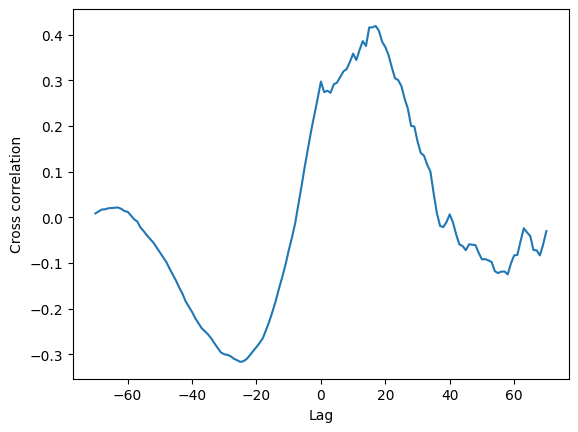

In [54]:
N = time.size
lags = np.arange(-N+1, N)
corr = np.correlate(pop_norm, temp_norm, 'full')
plt.plot(lags, corr/N)
plt.xlabel("Lag")
plt.ylabel("Cross correlation")

At zero lag, there is a positive cross correlation around 0.3.

It is interesting to see that it increases slightly within a 20-years lag of population time series. But here, we are simply using the population as a proxy of human activities that lead to local temperature incease. The lag may be explained by other factors, e.g., economic activities, city's green policy, global climate's fluctuation, etc. Hence, let's take zero lag in the following regression analysis.

Here, we build a regression model of the temperature against population to make predictions.

In [78]:
from scipy.stats import linregress, t

In [72]:
start, end = "1954", "2024"
pop = LD_pop[(LD_pop.year <= end) & (LD_pop.year >= start)].population.values
temp = LD_yearly_avg_over_sts.tavg.values

res = linregress(x = pop, y = temp)

Get fit statistics

In [84]:
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, pop.size-2)
print(f"slope (95%): {res.slope:.2g} +/- {ts*res.stderr:.2g}")
print(f"p-value: {res.pvalue}")

slope (95%): 3.1e-07 +/- 1.6e-07
p-value: 0.0003229321276504437


Visualise the fit

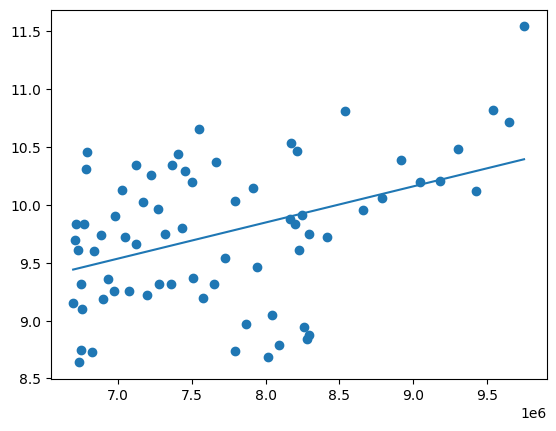

In [85]:
pop_vec = np.linspace(pop.min(), pop.max(), 1001)
plt.scatter(pop, temp)
plt.plot(pop_vec, res.intercept + res.slope*pop_vec)

Let's use this model to predict the future temperature. The population dataset contains the UN's population forecast in the next decade. We can use this as the input.

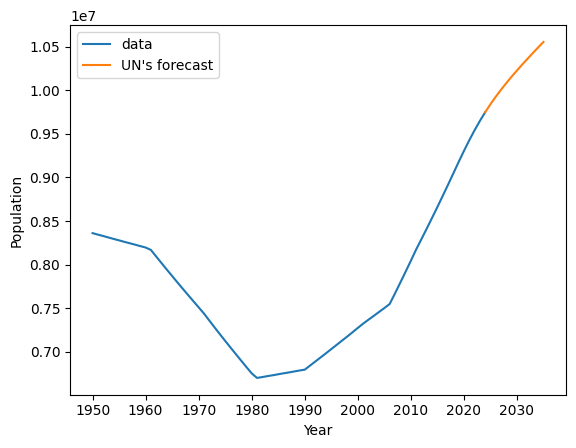

In [102]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_pop[LD_pop.year <= '2024'].year, LD_pop[LD_pop.year <= '2024'].population, label="data")
ax.plot(LD_pop[LD_pop.year >= '2024'].year, LD_pop[LD_pop.year >= '2024'].population, label="UN's forecast")
ax.set_xlabel("Year")
ax.set_ylabel("Population")
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);
ax.legend();

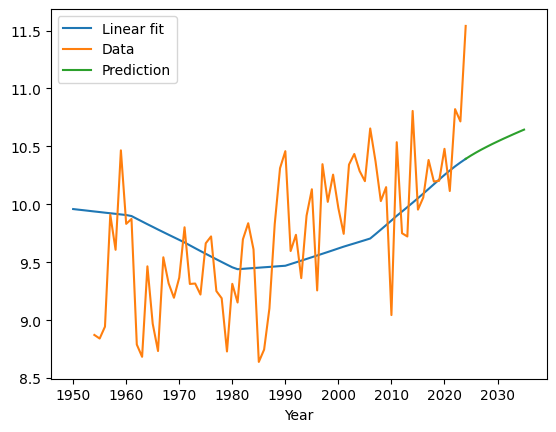

In [131]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(LD_pop[LD_pop.year <= '2024'].year, res.intercept + res.slope*LD_pop[LD_pop.year <= '2024'].population, label="Linear fit")
ax.plot(LD_yearly_avg_over_sts.year, LD_yearly_avg_over_sts.tavg, label="Data")
#ax.plot(LD_yearly_avg_over_sts.year, LD_yearly_avg_over_sts.tavg_ema, label="Data (EMA)")
ax.plot(LD_pop[LD_pop.year >= '2024'].year, res.intercept + res.slope*LD_pop[LD_pop.year >= '2024'].population, label="Prediction")
ax.set_xlabel("Year")
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
ax.set_xticks(xticks[::10]);
ax.set_xticklabels(xlabels[::10]);
ax.legend();

The average temperature is going to rise by 0.5 degree Celcius in the next decade!

Final note: this is a very simple linear fit, and has not captured all other interesting features. More advanced methods including ARMA and GPR can be explored in future for more realistic predictions.